## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [39]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np  
import re
from nltk.corpus import stopwords
from numpy import array 


from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Dense
from sklearn.model_selection import train_test_split

## Loading dataset

In [40]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [41]:
# Dataset exploration

movie_reviews.shape

(53500, 2)

In [42]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [43]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

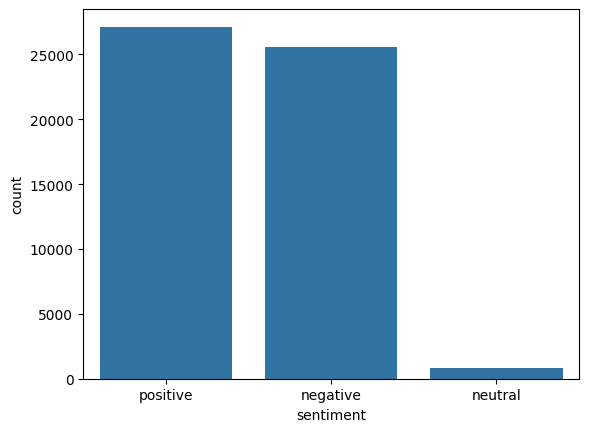

In [44]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [45]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [46]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [49]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [50]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [51]:
# Converting sentiment labels to 0 to netutral, -1 negative, 1 positive

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 0 if x== "negative" else 1 if x == "positive" else 2, y)))

print(y[0], y[1], y[3])

1 1 0


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [53]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [54]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

98917

In [55]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [56]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [57]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [58]:
embedding_matrix.shape

(98917, 100)

# Model Training with:

## Simple Neural Network

In [59]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/home/zaz/Documents/uni/tesis/tprototype/back/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [60]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     9,891,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,891,700 (37.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,891,700 (37.73 MB)

None


In [61]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.6519 - loss: 0.5886 - val_acc: 0.7412 - val_loss: 0.4661
Epoch 2/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7714 - loss: 0.4037 - val_acc: 0.7376 - val_loss: 0.4603
Epoch 3/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.7937 - loss: 0.3589 - val_acc: 0.7403 - val_loss: 0.4561
Epoch 4/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8045 - loss: 0.3160 - val_acc: 0.7428 - val_loss: 0.4576
Epoch 5/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.8142 - loss: 0.3074 - val_acc: 0.7404 - val_loss: 0.4684
Epoch 6/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8157 - loss: 0.2899 - val_acc: 0.7348 - val_loss: 0.4798


In [62]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7202 - loss: 0.5203


In [63]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5163708329200745
Test Accuracy: 0.7226168513298035


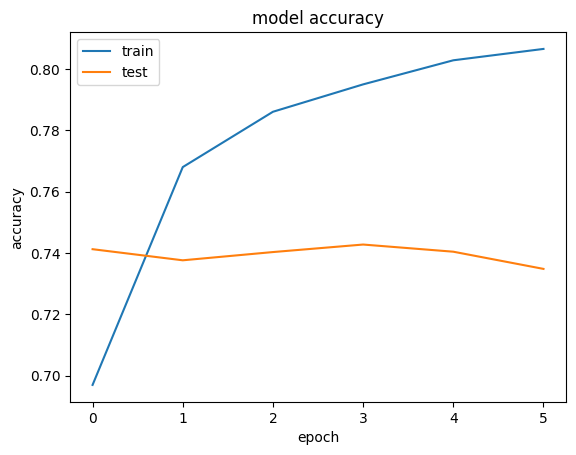

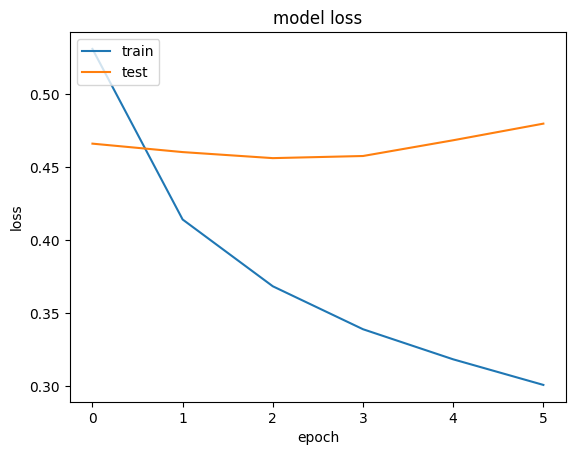

In [64]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [65]:
from keras.layers import Conv1D

In [66]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [67]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     9,891,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,891,700 (37.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,891,700 (37.73 MB)

None


In [68]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - acc: 0.6638 - loss: 0.5777 - val_acc: 0.8062 - val_loss: 0.3059
Epoch 2/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - acc: 0.8149 - loss: 0.2533 - val_acc: 0.8186 - val_loss: 0.2039
Epoch 3/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - acc: 0.8479 - loss: 0.1218 - val_acc: 0.8258 - val_loss: 0.0801
Epoch 4/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - acc: 0.8665 - loss: -0.0240 - val_acc: 0.8167 - val_loss: -0.0536
Epoch 5/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.8735 - loss: -0.2545 - val_acc: 0.7972 - val_loss: -0.1331
Epoch 6/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - acc: 0.8842 - loss: -0.5501 - val_acc: 0.8047 - val_loss: -0.3947


In [69]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.7947 - loss: -0.2133


In [70]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -0.244256392121315
Test Accuracy: 0.7977570295333862


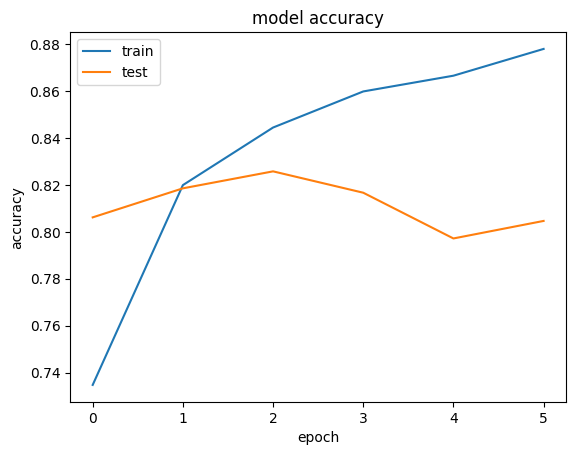

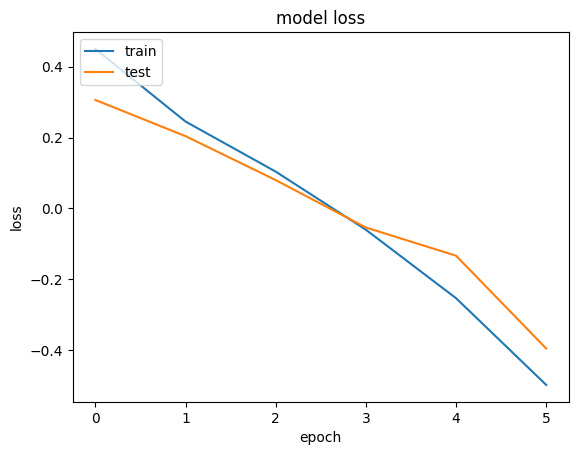

In [71]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [72]:
from keras.layers import LSTM

In [73]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [74]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     9,891,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,891,700 (37.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,891,700 (37.73 MB)

None


In [75]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 106s 380ms/step - acc: 0.6690 - loss: 0.5539 - val_acc: 0.7571 - val_loss: 0.3787
Epoch 2/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 64s 237ms/step - acc: 0.7344 - loss: 0.3893 - val_acc: 0.7974 - val_loss: 0.2776
Epoch 3/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - acc: 0.7857 - loss: 0.2762 - val_acc: 0.8006 - val_loss: 0.1169
Epoch 4/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 177ms/step - acc: 0.7497 - loss: 0.3627 - val_acc: 0.5798 - val_loss: 0.6562
Epoch 5/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - acc: 0.6262 - loss: 0.6022 - val_acc: 0.7459 - val_loss: 0.2735
Epoch 6/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - acc: 0.7647 - loss: 0.3009 - val_acc: 0.7921 - val_loss: 0.2320


In [76]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

335/335 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - acc: 0.7898 - loss: 0.2435


In [77]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.23117832839488983
Test Accuracy: 0.7910280227661133


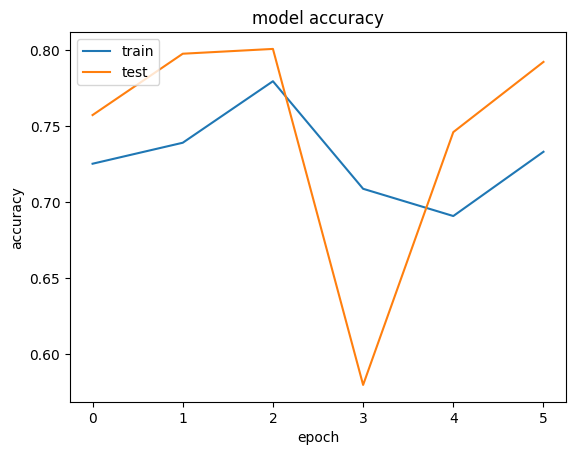

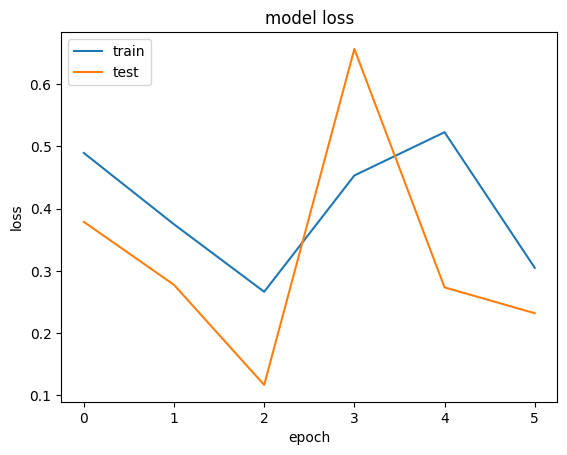

In [78]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [79]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [80]:
!ls # lists files in working directory

 a1_IMDB_Dataset.csv			        c2_IMDb_Unseen_Predictions.csv
 a2_glove.6B.100d.txt			        news_sentiment_analysis.csv
 a3_IMDb_Unseen_Reviews.csv		       'nnconv airlinecsv.ipynb'
 Airline-Sentiment-2-w-AA.csv		        nnconv.ipynb
 b_SentimentAnalysis_with_NeuralNetwork.ipynb  'nnlstm airlinecsv.ipynb'
 c1_lstm_model_acc_0.791.h5		       'nnlstm imdb.ipynb'
 c1_lstm_model_acc_0.846.h5		        nnlstm.ipynb
 c1_lstm_model_acc_0.863.h5


In [81]:
# # Load previously trained LSTM Model

from keras.models import load_model

model_path ='./c1_lstm_model_acc_0.863.h5'
pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [82]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [83]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [84]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [85]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


array([[0.8958292 ],
       [0.98558885],
       [0.03655767],
       [0.5591759 ],
       [0.9316956 ],
       [0.28211278]], dtype=float32)

In [86]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.0
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.4
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,5.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.3
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,2.8
